## Code

In [33]:
import csv
import random
import numpy as np
import math
import copy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import itertools
import pandas as pd

In [9]:
# tree class:
# each instance of the class contains a branch name, node name, and a list of its children (empty when initialised)
# can add as many children as you like (not a binary tree)
# nodes do not have references to their parents
class decision_tree:
    def __init__(self, branch_name, node_name):
        self.branch = branch_name
        self.node = node_name
        self.children = []
        
    def add_child(self, child_branch):
        self.children.append(child_branch)
        
# recursively draws the tree by printing the current node, and then calling itself on the node's children
# must be called with input 0 (indicates the first time the method is called, level 0)
    def draw_tree(self, level):
        if level == 0:
            print("root node:", self.node)
        else:
            print(level*"     ", "> --", self.branch, "--", self.node)
        if self.children != []:
            level = level + 1
            for child in self.children:
                child.draw_tree(level)

In [10]:
#calculates entropy given one probability
def get_entropy(probability):
    
# get 2nd probability from the first
# we know there are only two probabilities because there are 2 classes
    p1 = probability
    p2 = 1 - p1
    if p1 == 0 or p2 == 0:  #math.log will complain if we give it zero
        entropy = 0         #convention of entropy calculation
    else:
        entropy = -( p1*math.log(p1, 2) + p2*math.log(p2, 2) )    #entropy formula
    return entropy

In [11]:
# calculate gain of a given feature for a given distribution
def calculate_gain(distribution, entropy_of_dist, feature, feature_values):        
# get gain of the feature using formula
    gain = entropy_of_dist
    for f in feature_values:
        if len(distribution.loc[distribution[feature] == f]) == 0:
            entropy_of_feature = 0
        else:
            entropy_of_feature = get_entropy( len(distribution.loc[(distribution["class"] == "e") & (distribution[feature] == f)]) / len(distribution.loc[distribution[feature] == f]) )
        gain = gain - 1/len(distribution) * (len(distribution.loc[distribution[feature] == f])) * entropy_of_feature
    
    return gain

In [12]:
# finds the feature with the highest gain given a distribution(dataset)
# feature_values is a dictionary containing the feature values for each feature, the keys are names
def get_next_feature(distribution, entropy, feature_names, feature_values):
        
    best_gain = 0
    best_feature = ""
    for feature in feature_names:
        new_gain = calculate_gain(distribution, entropy, feature, feature_values[feature])
        if  new_gain > best_gain:
            best_gain = new_gain
            best_feature = feature
            
    return best_feature

In [13]:
# creates a branch of the tree and then calls itself recursively until either entropy is zero or the number of features
# to check has run out

# for each branch of the tree except the root, the branch name is the feature value of the parent of the branch
# the node name is the name of the next feature
# if the tree has reached an ending point, the node name is the proportion of that subset of the data which is edible
def create_branch(root, distribution, feature_values, feature_names):
# create copies of the feature names and values since these will be edited, but other calls to this function
# might need the original lists
    use_feature_values = copy.deepcopy(feature_values)
    use_feature_names = copy.deepcopy(feature_names)
            
    if len(distribution) == 0:     # if there is nothing in the distribution to check, leave the function
        return
    else:                          # if there is something to check, get the entropy of the data
        edible_count = len(distribution.loc[distribution["class"]=="e"])
        probability = edible_count/len(distribution)
        entropy = get_entropy(probability)

# if entropy is zero or there are no more features left to check, give the final probability of being edible
    if entropy == 0 or len(feature_values) == 0 or ( len(feature_values)==1 and len(distribution[feature_names[0]].unique())==1 ):
        probability = int(probability*100)
        root.node = str(probability) + " % probability of being edible"
        
# if entropy is not zero and there are still features to check
# get the feature with the most gain and set the node name of the current branch (input root) to that feature name
# then call this function for each child
    else:
        if len(feature_values) == 1:
            next_feature = use_feature_names[0]
        else:
            next_feature = get_next_feature(distribution, entropy, use_feature_names, use_feature_values)
            
        if next_feature == "":
            edible_count = len(distribution.loc[distribution["class"]=="e"])
            probability = edible_count/len(distribution)
            root.node = str(int(probability*100)) + " % probability of being edible"
        else:
            next_feature_values = use_feature_values.pop(next_feature)
            use_feature_names.remove(next_feature)
            root.node = next_feature
    
            for f in next_feature_values:
                if len((distribution.drop(columns = next_feature)).loc[data[next_feature] == f]) > 0:
                    tree_branch = decision_tree(f, "node_name")
                    root.add_child(tree_branch)
                    create_branch(tree_branch, (distribution.drop(columns = next_feature)).loc[data[next_feature] == f], use_feature_values, use_feature_names)

In [14]:
# creates the root node of the tree and then calls create branch for the first time
def create_tree(distribution, features_to_use):

    feature_values = {}
    for f in features_to_use:
        feature_values[f] = (list(distribution[f].unique()))
        
    root = decision_tree("root", "first feature")
    create_branch(root, distribution[["class"] + features_to_use], feature_values, features_to_use)
    return root

In [15]:
# test a tree given the root node and test data
# appends the true and predicted classes to predicted and truth lists
def test_tree(tree_root, test_data, predicted, truth):
    
# if at end of a branch:
# append the predicted class (edible if probability > 50) to predicted list, and true class to truth
# -1 for poisonous, 1 for edible
    if tree_root.children == []:
        for i in range(len(test_data)):
            if int(tree_root.node.split(" ")[0]) > 50:
                predicted.append(1)
            else:
                predicted.append(-1)
            
            if test_data.iloc[i][0] == "e":
                truth.append(1)
            else:
                truth.append(-1)
# call this function for each child of the current node
    else:    
        feature = tree_root.node
        for child in tree_root.children:
            test_tree(child, test_data.loc[test_data[feature] == child.branch], predicted, truth)

In [53]:
# calls test_tree for the first time and get the accuracy of the tree
# plots a confusion matrix of the results
def get_accuracy(tree_root, test_data):
    predicted_classes = []
    true_classes = []
    
    test_tree(tree_root, test_data, predicted_classes, true_classes)
    
    cm = confusion_matrix(true_classes, predicted_classes)

#plot confusion matrix
#taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    title = "Confusion Matrix"
    classes = ['poisonous','edible']
    cmap=plt.cm.BuPu
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if cm.max() > 1:
        thresh = cm.max()/2
    else:
        thresh = 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
#find accuracy
    accuracy = (cm[0][0] + cm[1][1])/(len(test_data))*100
    print("Accuracy = ", accuracy, "%")
    print("Total error:", 100-accuracy, "%")
    print("False poisonous:", cm[1,0])
    print("False edible:", cm[0,1])
    print("Total misclassifications:", cm[1,0] + cm[0,1])

## Results

In [40]:
# Reading in the data as a pandas dataframe
# Splitting into training and testing data (training = 60%)

f_names = ["class","cap-shape","cap-surface","cap-colour","bruises?","odor","gill-attachment",
           "gill-spacing","gill-size","gill-colour","stalk-shape","stalk-root","stalk-surface-above-ring",
           "stalk-surface-below-ring","stalk-colour-above-ring","stalk-colour-below-ring","veil-type",
           "veil-colour","ring-number","ring-type","spore-print-colour","population","habitat"]

data = pd.read_csv('agaricus-lepiota.data', names=f_names)
train, test = train_test_split(data, test_size=0.4)

#### Using all the features:

root node: odor
      > -- f -- 0 % probability of being edible
      > -- l -- 100 % probability of being edible
      > -- n -- spore-print-colour
           > -- w -- habitat
                > -- l -- cap-colour
                     > -- n -- 100 % probability of being edible
                     > -- w -- 0 % probability of being edible
                     > -- y -- 0 % probability of being edible
                     > -- c -- 100 % probability of being edible
                > -- g -- 100 % probability of being edible
                > -- w -- 100 % probability of being edible
                > -- d -- gill-size
                     > -- n -- 0 % probability of being edible
                     > -- b -- 100 % probability of being edible
                > -- p -- 100 % probability of being edible
           > -- k -- 100 % probability of being edible
           > -- h -- 100 % probability of being edible
           > -- n -- 100 % probability of being edible
           > -- r --

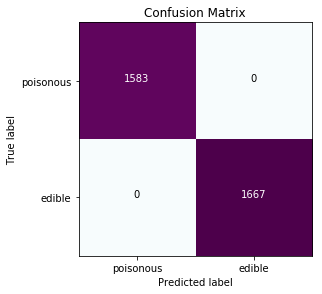

Accuracy =  100.0 %
Total error: 0.0 %
False poisonous: 0
False edible: 0
Total misclassifications: 0


In [54]:
features_to_use = ["cap-shape","cap-surface","cap-colour","bruises?","odor","gill-attachment",
                   "gill-spacing","gill-size","gill-colour","stalk-shape","stalk-root","stalk-surface-above-ring",
                   "stalk-surface-below-ring","stalk-colour-above-ring","stalk-colour-below-ring","veil-type",
                   "veil-colour","ring-number","ring-type","spore-print-colour","population","habitat"]
d_tree = create_tree(train, features_to_use)
d_tree.draw_tree(0)
get_accuracy(d_tree, test)

#### Using the 7 features mentioned in the rules for mushrooms as given by the source of the data:

root node: odor
      > -- f -- 0 % probability of being edible
      > -- l -- 100 % probability of being edible
      > -- n -- spore-print-colour
           > -- w -- habitat
                > -- l -- cap-colour
                     > -- n -- 100 % probability of being edible
                     > -- w -- 0 % probability of being edible
                     > -- y -- 0 % probability of being edible
                     > -- c -- 100 % probability of being edible
                > -- g -- 100 % probability of being edible
                > -- w -- 100 % probability of being edible
                > -- d -- stalk-colour-above-ring
                     > -- w -- 0 % probability of being edible
                     > -- n -- 100 % probability of being edible
                > -- p -- 100 % probability of being edible
           > -- k -- 100 % probability of being edible
           > -- h -- 100 % probability of being edible
           > -- n -- 100 % probability of being edible
      

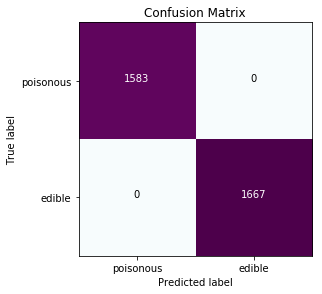

Accuracy =  100.0 %
Total error: 0.0 %
False poisonous: 0
False edible: 0
Total misclassifications: 0


In [55]:
features_to_use = ["cap-colour","odor","stalk-surface-below-ring","stalk-colour-above-ring",
                   "spore-print-colour","population","habitat"]
d_tree = create_tree(train, features_to_use)
d_tree.draw_tree(0)
get_accuracy(d_tree, test)

#### Using only cap-colour, odor and spore-print-colour:

root node: odor
      > -- f -- 0 % probability of being edible
      > -- l -- 100 % probability of being edible
      > -- n -- spore-print-colour
           > -- w -- cap-colour
                > -- n -- 88 % probability of being edible
                > -- w -- 94 % probability of being edible
                > -- y -- 0 % probability of being edible
                > -- g -- 100 % probability of being edible
                > -- b -- 100 % probability of being edible
                > -- e -- 100 % probability of being edible
                > -- p -- 100 % probability of being edible
                > -- c -- 100 % probability of being edible
           > -- k -- 100 % probability of being edible
           > -- h -- 100 % probability of being edible
           > -- n -- 100 % probability of being edible
           > -- r -- 0 % probability of being edible
           > -- o -- 100 % probability of being edible
           > -- b -- 100 % probability of being edible
           > --

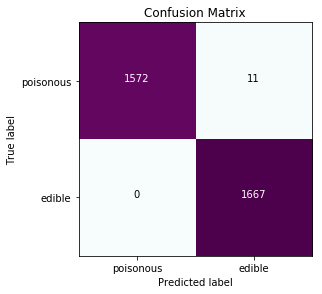

Accuracy =  99.66153846153846 %
Total error: 0.33846153846154436 %
False poisonous: 0
False edible: 11
Total misclassifications: 11


In [56]:
features_to_use = ["cap-colour","odor","spore-print-colour"]
d_tree = create_tree(train, features_to_use)
d_tree.draw_tree(0)
get_accuracy(d_tree, test)

#### Excluding all the features used in the first decision tree, as well as those mentioned in the rules for poisonous mushrooms:

root node: gill-colour
      > -- b -- 0 % probability of being edible
      > -- k -- bruises?
           > -- f -- 100 % probability of being edible
           > -- t -- stalk-root
                > -- c -- 100 % probability of being edible
                > -- e -- 0 % probability of being edible
      > -- p -- ring-type
           > -- e -- 100 % probability of being edible
           > -- p -- cap-surface
                > -- y -- stalk-root
                     > -- b -- 100 % probability of being edible
                     > -- r -- 100 % probability of being edible
                     > -- e -- 0 % probability of being edible
                > -- s -- gill-spacing
                     > -- c -- 0 % probability of being edible
                     > -- w -- stalk-root
                          > -- ? -- 100 % probability of being edible
                          > -- b -- bruises?
                               > -- f -- 0 % probability of being edible
                       

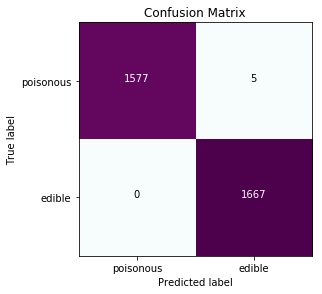

Accuracy =  99.81538461538462 %
Total error: 0.18461538461538396 %
False poisonous: 0
False edible: 5
Total misclassifications: 5


In [57]:
features_to_use = ["cap-shape","cap-surface","bruises?","gill-attachment",
                   "gill-spacing","gill-colour","stalk-shape","stalk-root","stalk-surface-above-ring",
                   "stalk-colour-below-ring","veil-type",
                   "veil-colour","ring-number","ring-type"]
d_tree = create_tree(train, features_to_use)
d_tree.draw_tree(0)
get_accuracy(d_tree, test)

#### Scikit-Learn Comparison

In [49]:
s = pd.get_dummies(train)
s = s.drop(columns = "class_p")
from sklearn import tree
X = s.iloc[:,1:]
Y = s.iloc[:,0]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
r = pd.get_dummies(test)
t = r["class_e"]
r = r.drop(columns = ["class_e", "class_p"])
p = clf.predict(r)
cm = confusion_matrix(t, p)
print(cm)
print("Accuracy:", 100*(cm[0,0]+cm[1,1])/len(test))

[[1583    0]
 [   0 1667]]
Accuracy: 100.0
